In [1]:
import numpy as np
import pandas as pd

# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/BLA_LFP_data/Part2SubjectHB15_AW.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine_syn_noise.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'
INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/FR_PN_ITN.txt'

In [2]:
from lfp_prediction.data_gathering import MatlabCollector, NumpyCollector, TextCollector

frequency_band = (55, 85)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
    del data
    del labels
dc = TextCollector(INVIVO_RAW_PATH)
dc.get_data(column=2)
data, labels = dc.filter_data(filter_type='non-causal',
                              freq_band=frequency_band,
                              filter_rate=400,
                              only_bursts=False)

data = data[:10000]

In [3]:
from scipy.fft import rfft


freq_data = rfft(data, axis=2)
print(data.shape)

(7500, 1, 300)


In [4]:
from scipy import signal, io, fft, stats
from lfp_prediction.config import params
from tqdm.notebook import tqdm
import re


def get_invivo():

    mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
    df_list = []

    for i, arr in enumerate(mat):
        if i == 0:
            vals = arr[0]
            continue
        np.append(vals, arr[0])

    for arr in tqdm(mat):
        if arr[0].shape[0] == 1:
            arr[0] = np.transpose(arr[0], axes=(1,0))
        # print(arr[0].shape)
        if arr[0].shape[0] < (params.PREVIOUS_TIME + params.LOOK_AHEAD):
            continue
        df_list.append(pd.DataFrame(arr[0]))
    return df_list

def get_feng(column: int = None):
    with open(INVIVO_RAW_PATH, 'r') as f:
        data = f.readlines()
        
    if column:
        data = [re.findall(r'\d+', d)[column-1] for d in data]
        data = np.array(list(map(float, data))).reshape((-1, 1))
    else:
        data = np.array(list(map(float, data))).reshape((-1, 1))
        
    global_std = np.std(data)
    global_mean = np.mean(data)
    df_list = [pd.DataFrame(((data - global_mean) / global_std))]
    return df_list

df_list = get_feng(column=2)
df_list[0].drop(labels=df_list[0].index[200000:],
                axis=0,
                inplace=True)
print(len(df_list[0].index))
df_list[0].head()

# df_list = generate_noise()

200000


,0
0,-0.991074
1,-0.991074
2,-0.991074
3,-0.991074
4,-0.991074


In [5]:
large_df = pd.concat(df_list, axis=1)
large_df.columns = [str(i) for i in range(len(df_list))]
large_df

,0
0,-0.991074
1,-0.991074
2,-0.991074
3,-0.991074
4,-0.991074
...,...
199995,-0.366073
199996,0.743304
199997,0.102678
199998,-0.366073


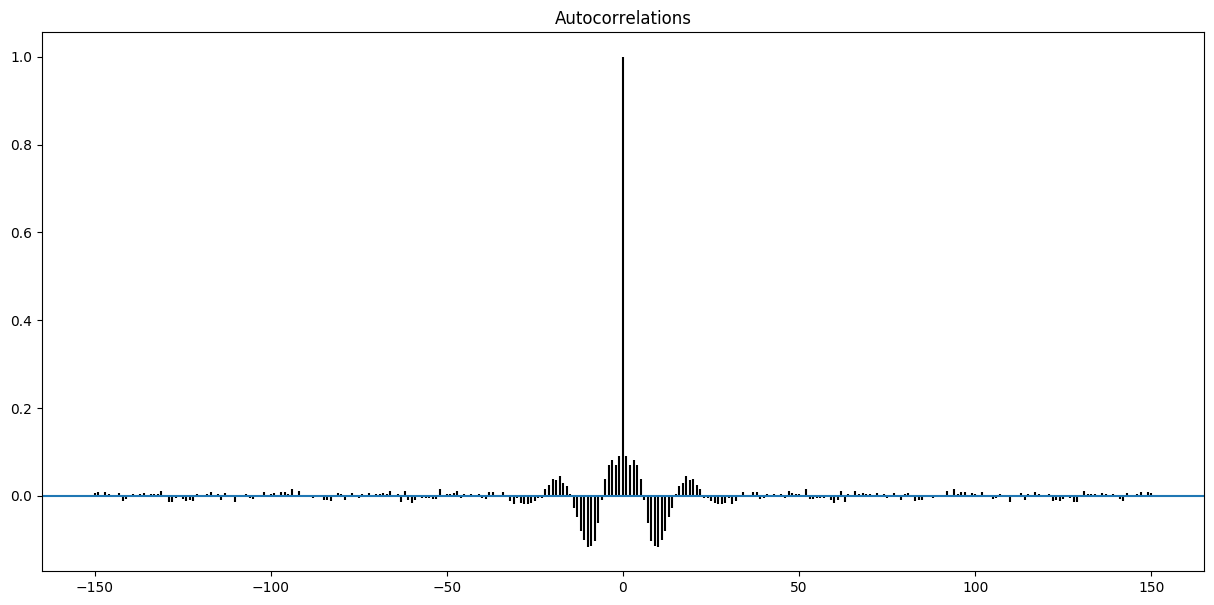

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,7))
plt.acorr(np.squeeze(df_list[0].to_numpy(dtype=float)[:20000]), maxlags=150)
plt.title('Autocorrelations')
plt.show()

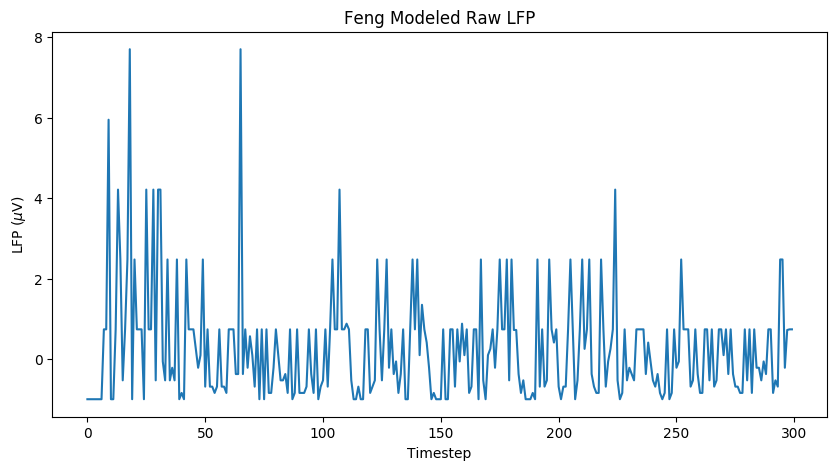

In [7]:
# %matplotlib notebook

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(df_list[0][0]))[:300], df_list[0][0][:300])
plt.title('Feng Modeled Raw LFP')
plt.xlabel('Timestep')
plt.ylabel(r'LFP ($\mu$V)')
plt.show()

(100001,)


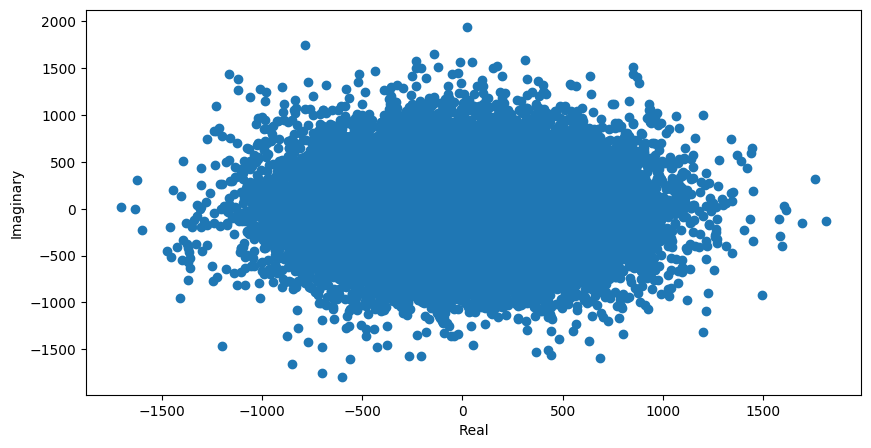

In [8]:
plt.figure(figsize=(10,5))

freq = rfft(df_list[0][0].to_numpy())

print(freq.shape)

# extract real part
x = [ele.real for ele in freq]
# extract imaginary part
y = [ele.imag for ele in freq]
  
# plot the complex numbers
plt.scatter(x, y)
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.show()

(100001,)


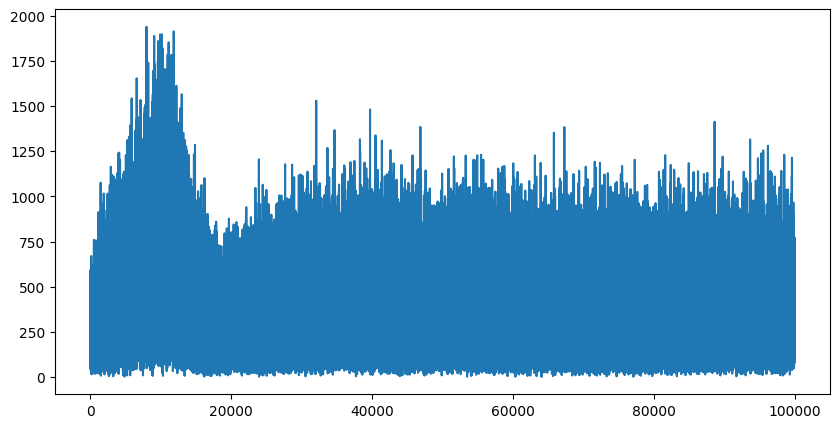

In [9]:
abs_freq = np.absolute(freq)
print(abs_freq.shape)

plt.figure(figsize=(10,5))
plt.plot(np.arange(abs_freq.shape[0]), abs_freq)
plt.show()

(7500, 1, 151)


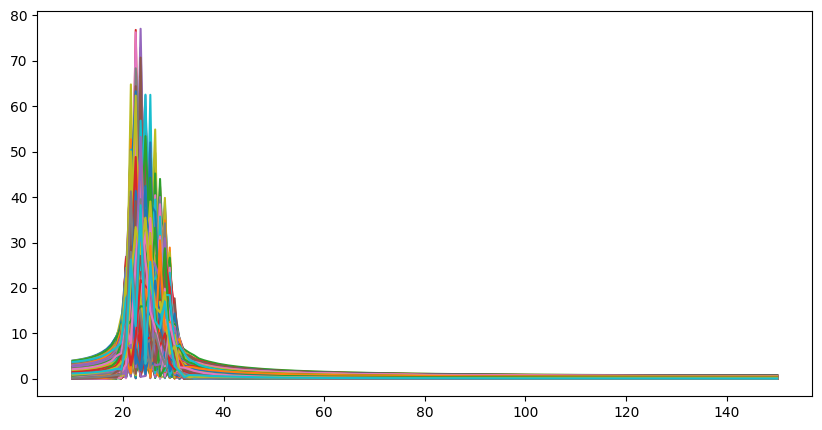

In [10]:
abs_freq_data = np.absolute(freq_data)
print(abs_freq_data.shape)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(10, 150, abs_freq_data.shape[2]-5), abs_freq_data[:,0,5:].T)
plt.show()

In [11]:
max_arr = np.amax(abs_freq_data[:,0,5:], axis=1)
print('Min: {:.2f} at {} and Max: {:.2f} at {}'.format(np.amin(max_arr), 
                                                       np.argmin(max_arr), 
                                                       np.amax(max_arr), 
                                                       np.argmax(max_arr)))

print(np.mean(max_arr))

Min: 12.40 at 4759 and Max: 77.07 at 1934
34.02558230540415


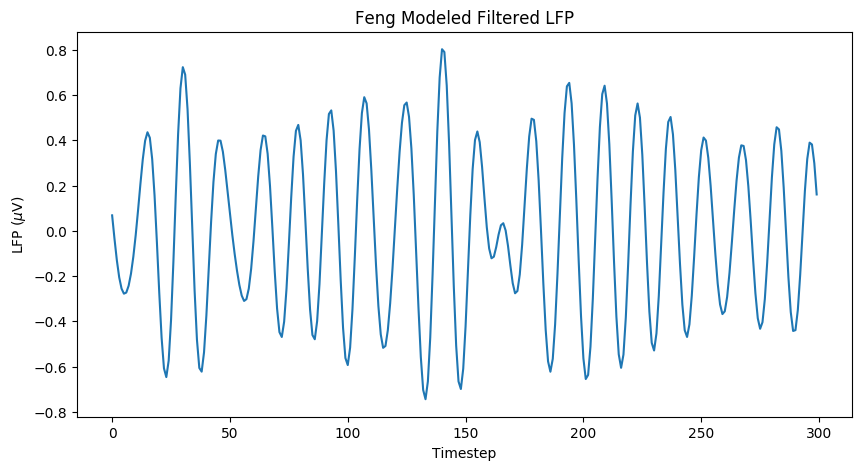

In [12]:
z, a = signal.butter(4, np.array([55,85]), btype='bandpass', output='ba', fs=1000)
lfp = signal.filtfilt(z, a, df_list[0][0], axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(lfp))[:300], lfp[:300])
plt.title('Feng Modeled Filtered LFP')
plt.xlabel('Timestep')
plt.ylabel(r'LFP ($\mu$V)')
plt.show()

In [13]:
LFP_amp = abs(signal.hilbert(lfp))
threshold = np.mean(LFP_amp) + (1 * np.std(LFP_amp))

masked_array = np.ma.masked_outside(lfp, -threshold, threshold)
print(masked_array.data.shape)
print(masked_array.mask)
# print(res)
# print(threshold)
falses = 0
trues = 0
for val in masked_array.mask:
    if val:
        trues += 1
    else:
        falses += 1

print("Falses: {}, Trues: {}".format(falses, trues))
print("Percentage: {:2.2f}%".format((trues/(falses + trues)) * 100))

(200000,)
[False False False ... False False False]
Falses: 188875, Trues: 11125
Percentage: 5.56%


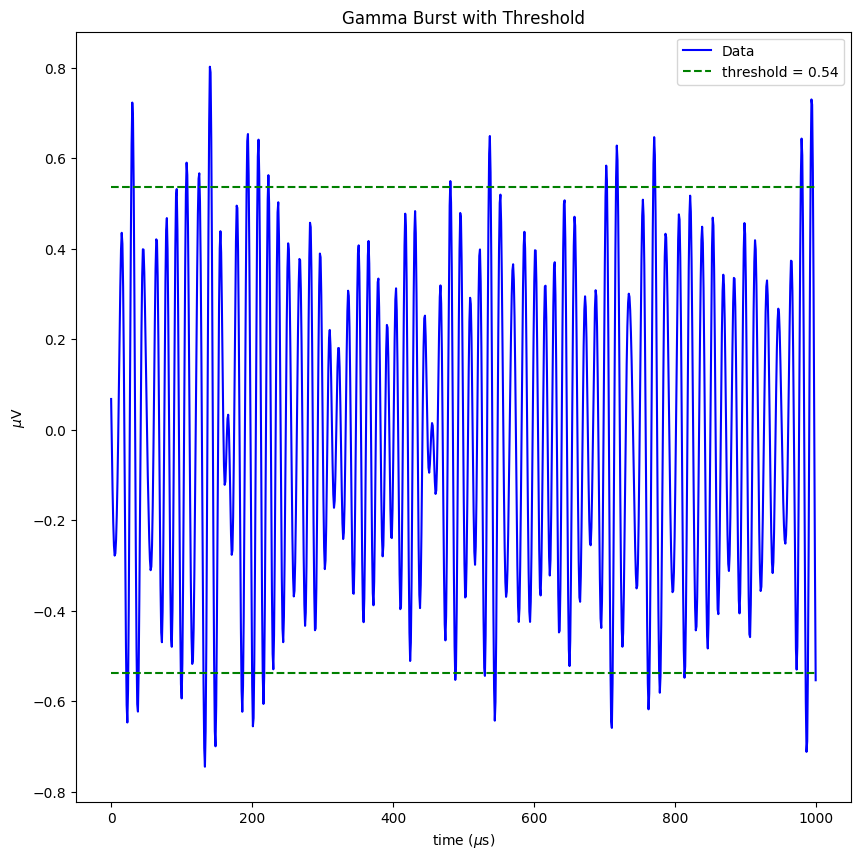

In [14]:
import matplotlib.pyplot as plt

range = (0, 1000)
plt.figure(figsize=(10,10))
plt.plot(np.arange(masked_array.data.shape[0])[range[0]:range[1]],
         masked_array.data[range[0]:range[1]],
         'blue',
         label='Data')
plt.plot(np.arange(masked_array.data.shape[0])[range[0]:range[1]],
         np.full(shape=masked_array.data.shape, fill_value=threshold)[range[0]:range[1]],
         'g--',
         label='threshold = {:3.2f}'.format(threshold))
plt.plot(np.arange(masked_array.data.shape[0])[range[0]:range[1]],
         np.full(shape=masked_array.data.shape, fill_value=-threshold)[range[0]:range[1]],
         'g--')

# plt.plot([range[0]*1.5, range[0]*1.5], [-400, 400], 'r--')
plt.title('Gamma Burst with Threshold')
plt.ylabel(r'$\mu$V')
plt.xlabel(r'time ($\mu$s)')
plt.legend()
plt.show()


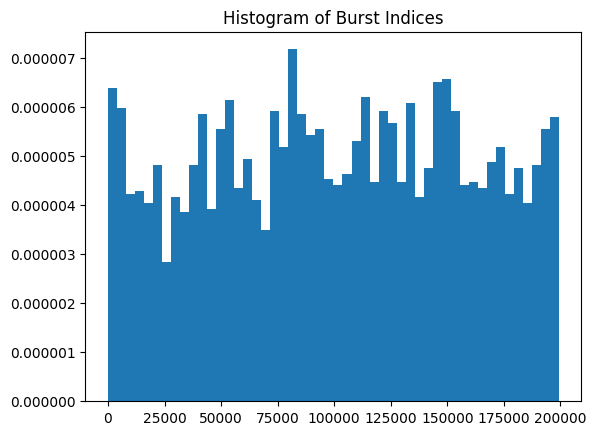

In [15]:
max_extrema_idx = signal.argrelextrema(lfp, np.greater)[0]
min_extrema_idx = signal.argrelextrema(lfp, np.less)[0]

extrema_idx = np.empty((max_extrema_idx.size + min_extrema_idx.size,), dtype=max_extrema_idx.dtype)
extrema_idx[0::2] = max_extrema_idx
extrema_idx[1::2] = min_extrema_idx
lfp_extrema = lfp[extrema_idx]
masked_extrema_array = np.ma.masked_outside(lfp_extrema, -threshold, threshold)
falses = 0
trues = 0
for val in masked_extrema_array.mask:
    if val:
        trues += 1
    else:
        falses += 1

plt.hist(extrema_idx[masked_extrema_array.mask].data, bins=50, density=True)
plt.title('Histogram of Burst Indices')
plt.show()

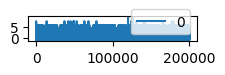

In [16]:
def filter_dataframe_lfp(lfp):
    z, a = signal.butter(4, np.array([55,85]), btype='bandpass', output='ba', fs=1000)
    lfp = signal.filtfilt(z, a, lfp, axis=0)
    return lfp
large_df.apply(filter_dataframe_lfp, axis=0)
large_df.plot(y=large_df.columns.to_list(), kind='line', subplots=True, layout=(13,4), figsize=(10, 5))
plt.show()

In [17]:
vals = []
for i, df in enumerate(df_list):
    vals.extend(df.values.tolist())
    
global_std = np.std(np.array(vals))
global_mean = np.mean(np.array(vals))
print(global_std, global_mean)

1.0013750773229342 0.001188785612679786


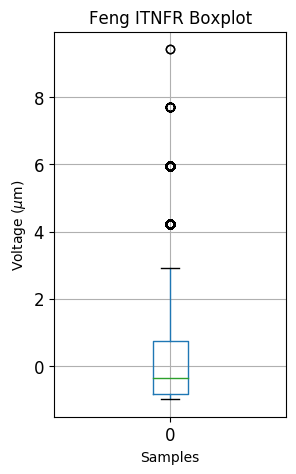

In [18]:
large_df.boxplot(fontsize='large', figsize=(3,5))
plt.title('Feng ITNFR Boxplot')
plt.xlabel('Samples')
plt.ylabel(r'Voltage ($\mu$m)')
plt.show()

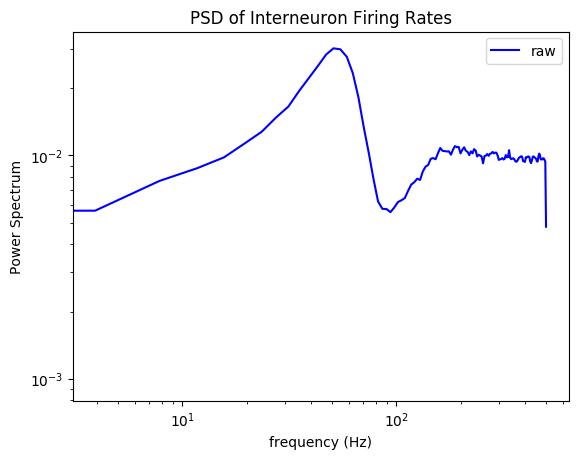

In [19]:
from scipy.signal import periodogram, welch

numpy_signal = df_list[0][0].to_numpy()

f, Pxx = signal.welch(numpy_signal, fs=1000, window='hamming', nperseg=2**8, scaling='spectrum')
plt.loglog(f, Pxx, 'b', label='raw')
plt.title('PSD of Interneuron Firing Rates')
plt.xlabel("frequency (Hz)")
plt.ylabel("Power Spectrum")
plt.legend()
plt.show()